In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))\

import numpy as np
import pandas as pd
import GPy
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError:
    pass
    
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
    
%matplotlib inline

In [8]:
df=pd.read_csv('bitcoin_20172018april.csv')

In [9]:
df=df[:-2]
df["Dataindex"] = df.index                        ## Keep index, could be usefull
df.index=df.Date    
df.index=df.index.to_datetime()
df=df.drop(columns=['Date'])

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning:to_datetime is deprecated. Use pd.to_datetime(...)


In [10]:
df

,Close Price,Dataindex
2017-04-10 00:00:00,1213.34,0
2017-04-11 00:00:00,1224.77,1
2017-04-12 00:00:00,1216.50,2
2017-04-13 00:00:00,1178.53,3
2017-04-14 00:00:00,1183.44,4
2017-04-15 00:00:00,1180.70,5
2017-04-16 00:00:00,1184.79,6
2017-04-17 00:00:00,1203.73,7
2017-04-18 00:00:00,1217.60,8
2017-04-19 00:00:00,1226.94,9


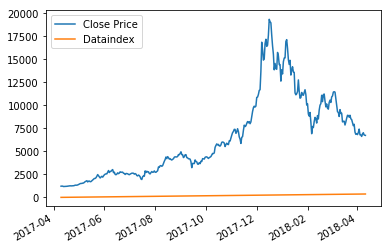

In [11]:
df.plot()

In [12]:
week_avg=df.groupby([df.index.weekday]).mean()

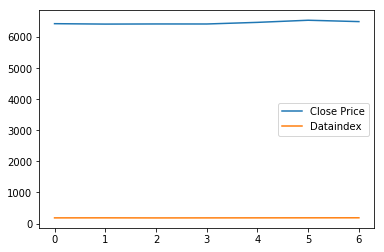

In [13]:
week_avg.plot()

In [14]:
df['Change']=df['Close Price'].pct_change()

In [15]:
week_avg_change=df['Change'].groupby([df.index.weekday]).mean()

In [86]:
week_std=df['Change'].groupby([df.index.weekday]).std()

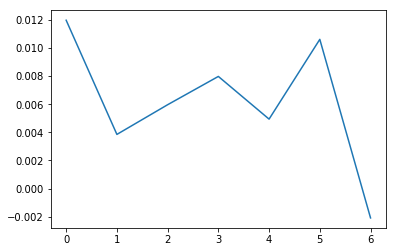

In [95]:
week_avg_change.plot()

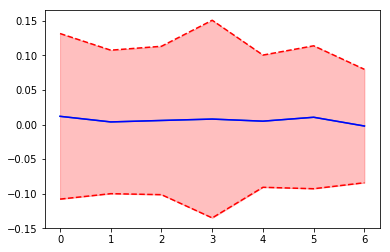

In [92]:
#0=monday
#when plotting std, it seems there is not a real trend in weekday. 
#Interesting that Thursday is more uncertain. 
week_avg_change.plot()
plt.plot(range(7),week_avg_change,color='b')
plt.plot(range(7),week_avg_change+2*week_std,color='r' ,linestyle='--')
plt.plot(range(7),week_avg_change-2*week_std,color='r' ,linestyle='--')
plt.fill_between(range(7),week_avg_change+2*week_std,week_avg_change-2*week_std,color='r',alpha=0.25)

In [17]:
week_avg_change

0    0.011961
1    0.003852
2    0.005961
3    0.007970
4    0.004939
5    0.010603
6   -0.002079
Name: Change, dtype: float64

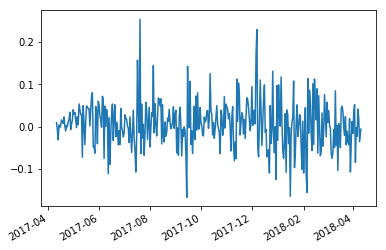

In [18]:
df['Change'].plot()

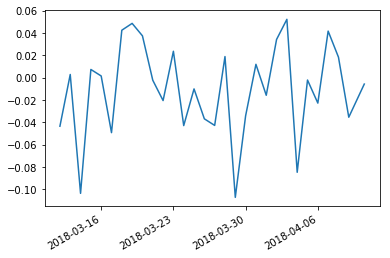

In [19]:
df['Change'][-30:].plot()

In [51]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"]).reshape(-1, 1)

X = np.array(df["Dataindex"]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


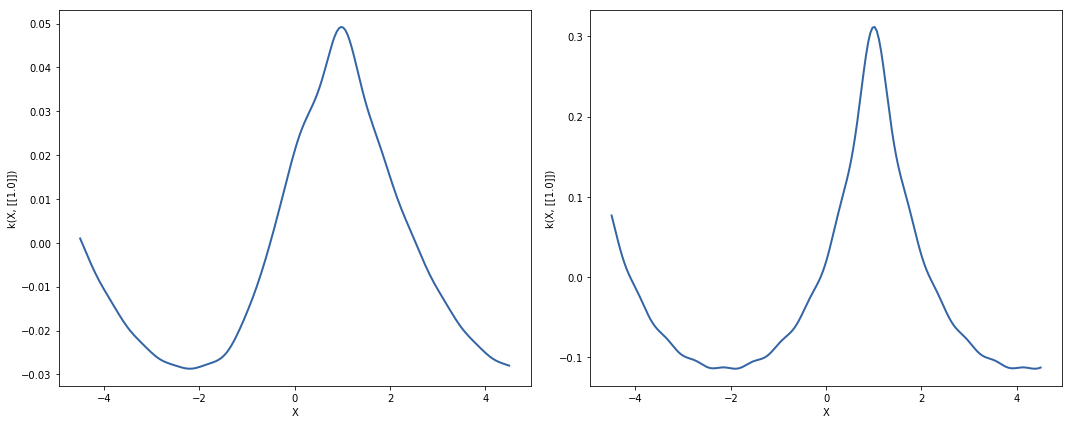

In [102]:
figure, axes = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
k=GPy.kern.PeriodicExponential(input_dim=1,variance=249752,lengthscale=3193965,period=7)
k.plot(ax=axes[0])
k=GPy.kern.PeriodicExponential(input_dim=1)
k.plot(ax=axes[1])

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


GP_regression.,value,constraints,priors
sum.mul.rbf.variance,200072.61646316457,+ve,
sum.mul.rbf.lengthscale,10.754982503053165,+ve,
sum.mul.bias.variance,164.33947886078803,+ve,
sum.periodic_exponential.variance,249752.93752744162,+ve,
sum.periodic_exponential.lengthscale,3193965.5971837286,+ve,
sum.periodic_exponential.period,7.0,fixed +ve,
Gaussian_noise.variance,277209.0946487546,+ve,


(array([[-0.00051165]]), array([[33157038.66300759]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


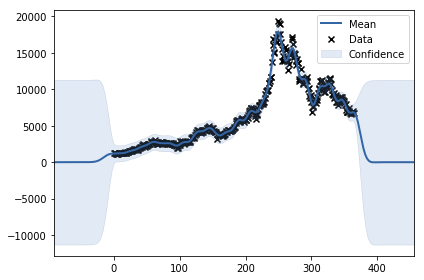

In [96]:
#Janne's cool stuff
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1, variance=200000., lengthscale=20.)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1, variance=8000, lengthscale=0.5, period=7)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1, variance=250000, lengthscale=20, period=7)
EXP_PER.period.fix()
LIN = GPy.kern.Linear(1, variances=55000)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)

RBF_PER = RBF*BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3

m = GPy.models.GPRegression(X, Y, RBF_PER)
m.optimize()
display(m)

m.plot()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [108]:
m

GP_regression.,value,constraints,priors
sum.mul.rbf.variance,200072.61646316457,+ve,
sum.mul.rbf.lengthscale,10.754982503053165,+ve,
sum.mul.bias.variance,164.33947886078803,+ve,
sum.periodic_exponential.variance,249752.93752744162,+ve,
sum.periodic_exponential.lengthscale,3193965.5971837286,+ve,
sum.periodic_exponential.period,7.0,fixed +ve,
Gaussian_noise.variance,277209.0946487546,+ve,


In [112]:
m.parameters_changed

<bound method GP.parameters_changed of <GPy.models.gp_regression.GPRegression object at 0x7f003b548da0>>

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
sum.mul.rbf.variance,199983.75976015048,+ve,
sum.mul.rbf.lengthscale,11.885030631847558,+ve,
sum.mul.bias.variance,161.8328421549655,+ve,
sum.periodic_exponential.variance,249790.31343999555,+ve,
sum.periodic_exponential.lengthscale,2576204.4227263606,+ve,
sum.periodic_exponential.period,7.0,fixed +ve,
Gaussian_noise.variance,221344.40997291167,+ve,


(array([[-0.00046087]]), array([[32585284.691958]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


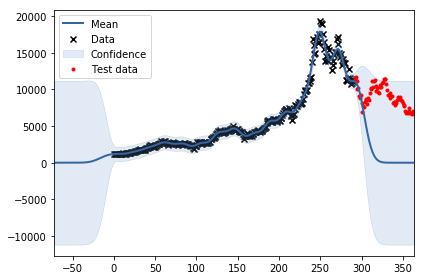

In [94]:
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1, variance=200000., lengthscale=20.)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1, variance=8000, lengthscale=0.5, period=7)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1, variance=250000, lengthscale=20, period=7)
EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1, variances=55000)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)

RBF_PER = RBF*BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3

m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
sum.rbf.variance,0.3891574738712041,+ve,
sum.rbf.lengthscale,0.99516786827195,+ve,
sum.periodic_exponential.variance,0.9021632291411033,+ve,
sum.periodic_exponential.lengthscale,1.0655527917770327,+ve,
sum.periodic_exponential.period,10.961660673138379,+ve,
Gaussian_noise.variance,0.42146994757672424,+ve,


(array([[-0.27750049]]), array([[0.84907038]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


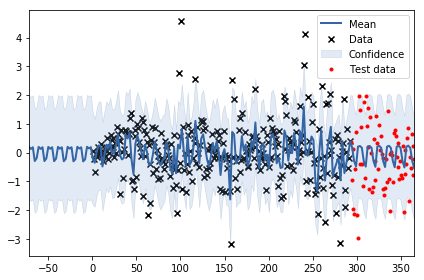

In [84]:
RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1,lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1)
#EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)

RBF_PER = RBF+ EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3

m = GPy.models.GPRegression(Xc_train, Yc_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(Xc_test,Yc_test,c='r',marker='.',label='Test data')
#plt.plot(X[1:],Yc[1:])
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [44]:
#tried normalizing it, but doesn't really seem to mater for current model
Y_norm=scale(Y)

In [81]:
Yc=np.array(df["Change"][1:]).reshape(-1,1)
Yc=scale(Yc)
Yc_train=Yc[:split_ind]
Yc_test=Yc[split_ind:]
Xc=X[1:]
Xc_train=Xc[:split_ind]
Xc_test=Xc[split_ind:]

In [ ]:
## RANDOM SEARCH FOR THE OPTIMAL PARAMETERS?